Link to my repository:

https://github.com/ryangreen6/Time-Series-Plots-RG



In [1]:
# Import necessary packages

import xarray as xr
import matplotlib.pyplot as plt
import intake
import s3fs
import pandas as pd
import numpy as np

In [2]:
# Open the CMIP6 data catalog, store as a variable
catalog = intake.open_esm_datastore('https://cmip6-pds.s3.amazonaws.com/pangeo-cmip6.json')

In [3]:
# Specify search terms to query catalog for CanESM5 data
# activity_id: which project do you want? CMIP = historical data, ScenarioMIP = future projections
activity_ids = ['ScenarioMIP', 'CMIP'] 

# source_id: which model do you want? 
source_id = ['CanESM5']

# experiment_id: what experimental configuration do you want? Here we want historical and the four main SSPs
experiment_ids = ['historical', 'ssp126', 'ssp245', 'ssp370', 'ssp585']

# member_id: which ensemble member do you want? Here we want r10i1p1f1
member_id = 'r10i1p1f1'

# table_id: which part of the Earth system and time resolution do you want? Here we want monthly atmosphere data
table_id = 'Amon' 

# variable_id: which climate variable do you want? Here we want surface air temperature
variable_id = 'tas' 

In [4]:
# Search through catalog, store results in "res" variable
res = catalog.search(activity_id=activity_ids, source_id=source_id, experiment_id=experiment_ids, 
                     member_id=member_id, table_id=table_id, variable_id=variable_id)

# Display data frame associated with results
display(res.df)

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
0,CMIP,CCCma,CanESM5,historical,r10i1p1f1,Amon,tas,gn,s3://cmip6-pds/CMIP6/CMIP/CCCma/CanESM5/histor...,NaN,20190429
1,ScenarioMIP,CCCma,CanESM5,ssp585,r10i1p1f1,Amon,tas,gn,s3://cmip6-pds/CMIP6/ScenarioMIP/CCCma/CanESM5...,NaN,20190429
2,ScenarioMIP,CCCma,CanESM5,ssp370,r10i1p1f1,Amon,tas,gn,s3://cmip6-pds/CMIP6/ScenarioMIP/CCCma/CanESM5...,NaN,20190429
3,ScenarioMIP,CCCma,CanESM5,ssp126,r10i1p1f1,Amon,tas,gn,s3://cmip6-pds/CMIP6/ScenarioMIP/CCCma/CanESM5...,NaN,20190429
4,ScenarioMIP,CCCma,CanESM5,ssp245,r10i1p1f1,Amon,tas,gn,s3://cmip6-pds/CMIP6/ScenarioMIP/CCCma/CanESM5...,NaN,20190429


In [5]:
# Read in the historical data file
hist_data = xr.open_zarr(res.df['zstore'][0], storage_options={'anon': True})

# Read in the SSP370 data file
ssp370_data = xr.open_zarr(res.df['zstore'][2], storage_options={'anon': True})

In [6]:
# Concatenate historical and future projection data
canesm5_data = xr.concat([hist_data, ssp370_data], dim="time")

In [7]:
# Convert time to datetime64 format
time = canesm5_data.time.astype('datetime64[ns]')

In [8]:
# Define min/max bounds for region of interest (Aegean Sea)
lat_min, lat_max = 34, 42
lon_min, lon_max = 19, 30

# Define logical mask: True when lat/lon inside the valid ranges, False elsewhere
tas_aeg_lat = (canesm5_data.lat >= lat_min) & (canesm5_data.lat <= lat_max)
tas_aeg_lon = (canesm5_data.lon >= lon_min) & (canesm5_data.lon <= lon_max)

# Find points where the mask value is True, drop all other points
tas_aeg = canesm5_data.where(tas_aeg_lat & tas_aeg_lon, drop=True)

# Average over lat, lon dimensions to get a time series
tas_aeg = tas_aeg.mean(dim=["lat", "lon"])

For this assignment I chose the Aegean Sea. This is a Medterranean climate characterized by hot summers and mild, wet winters. Vegetation is mainly medterranean forest, sparse woodlands, and scrubland.

Climate change impacts that could effect this region are drought due to changed precipitation patterns, marine heat waves, and of course sea level rise. 

In [9]:
# Checking contents of the xarray
tas_aeg

<xarray.Dataset>
Dimensions:    (time: 3012, bnds: 2)
Coordinates:
    height     float64 2.0
  * time       (time) object 1850-01-16 12:00:00 ... 2100-12-16 12:00:00
    time_bnds  (time, bnds) object dask.array<chunksize=(1980, 2), meta=np.ndarray>
Dimensions without coordinates: bnds
Data variables:
    tas        (time) float32 dask.array<chunksize=(600,), meta=np.ndarray>

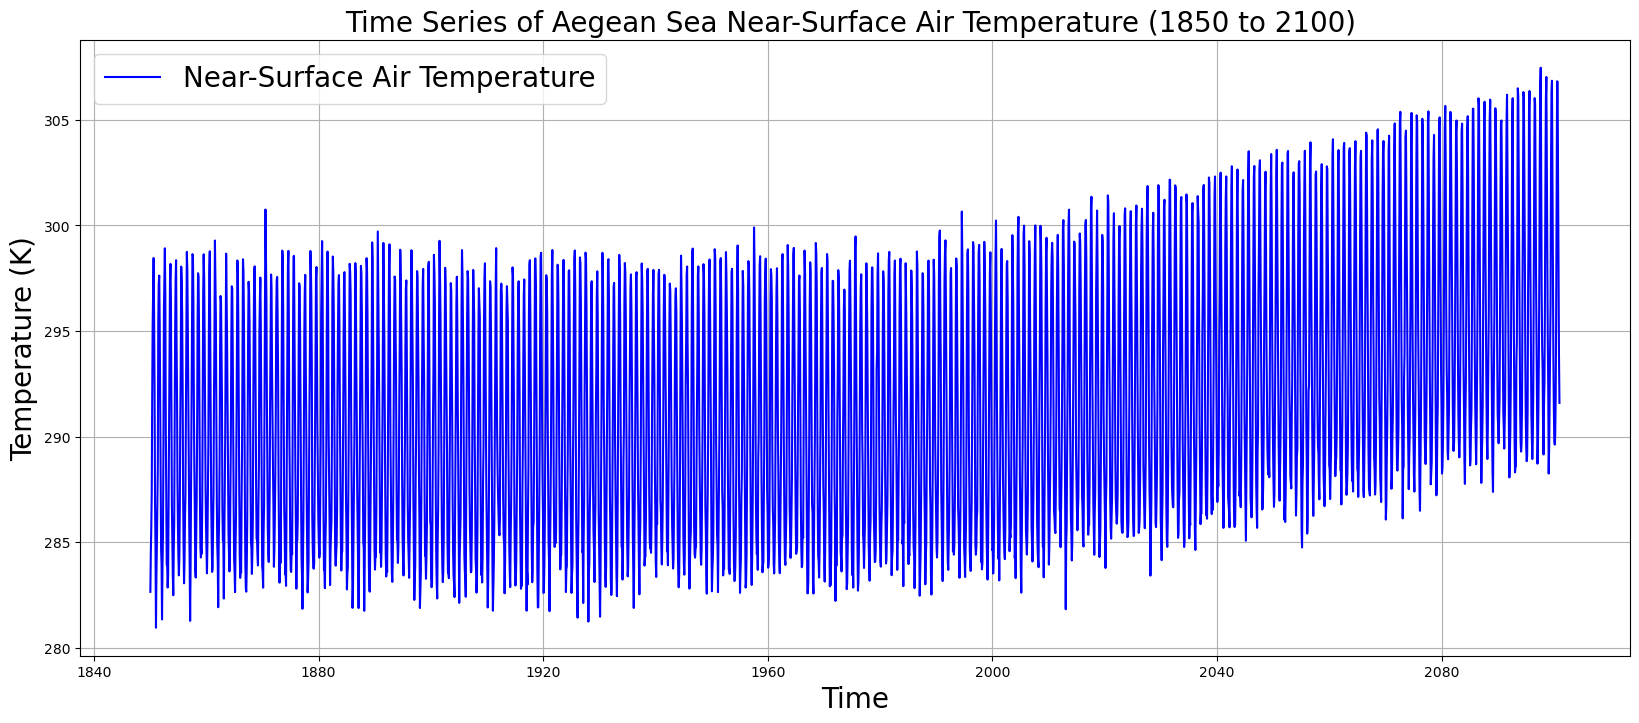

In [10]:
# Plotting temperatures
fig, ax = plt.subplots(figsize=(20, 8))
ax.plot(time, tas_aeg.tas, label='Near-Surface Air Temperature', color='b')
ax.set_title("Time Series of Aegean Sea Near-Surface Air Temperature (1850 to 2100) ", fontsize=20)
ax.set_xlabel("Time", fontsize=20)
ax.set_ylabel("Temperature (K)", fontsize=20)
ax.legend(fontsize=20)
ax.grid()
plt.show()

In [11]:
# Select a time period of interest -- two time periods for this assignment
tas_aeg_2100 = tas_aeg.sel(time=slice('1850-01-16','2100-12-31'))
tas_aeg_2015 = tas_aeg.sel(time=slice('1850-01-16','2015-12-31'))

In [12]:
# Dropping the time_bnds variable 
tas_aeg_2100 = tas_aeg_2100.drop_vars("time_bnds")
tas_aeg_2015 = tas_aeg_2015.drop_vars("time_bnds")

In [13]:
# confirming dropped variable
tas_aeg_2015
tas_aeg_2100

<xarray.Dataset>
Dimensions:  (time: 3012)
Coordinates:
    height   float64 2.0
  * time     (time) object 1850-01-16 12:00:00 ... 2100-12-16 12:00:00
Data variables:
    tas      (time) float32 dask.array<chunksize=(600,), meta=np.ndarray>

In [14]:
# calculating annual mean 
annual_mean_2100 = tas_aeg_2100.groupby('time.year').mean()
annual_mean_2015 = tas_aeg_2015.groupby('time.year').mean()

In [15]:
# converting to celsius from Kelvin
annual_mean_2100 = annual_mean_2100 - 273.15
annual_mean_2015 = annual_mean_2015 - 273.15

In [16]:
# Adding this cell to note that I wasn't able to get this chunk from the tutorial working:

# # Calculate best-fit parameters for the linear polynomial fit of temperature to year
# x = np.polyfit(annual_mean.year, annual_mean, 1)

# # Generate a polynomial object using those best-fit parameters
# trend_line = np.poly1d(x)  


# The cell below is my workaround

In [17]:
# Pull out the DataArrays (variable name “tas”)
da_2100 = annual_mean_2100["tas"]
da_2015 = annual_mean_2015["tas"]

# Grab arrays for 2100 and 2015
years_2100 = da_2100["year"].values
temps_2100 = da_2100.values
years_2015 = da_2015["year"].values
temps_2015 = da_2015.values

# Fitting separate trend lines
coeffs_2100     = np.polyfit(years_2100, temps_2100, 1)
trend_line_2100 = np.poly1d(coeffs_2100)

coeffs_2015     = np.polyfit(years_2015, temps_2015, 1)
trend_line_2015 = np.poly1d(coeffs_2015)

# evaluate the fits
fit_2100 = trend_line_2100(years_2100)
fit_2015 = trend_line_2015(years_2015)

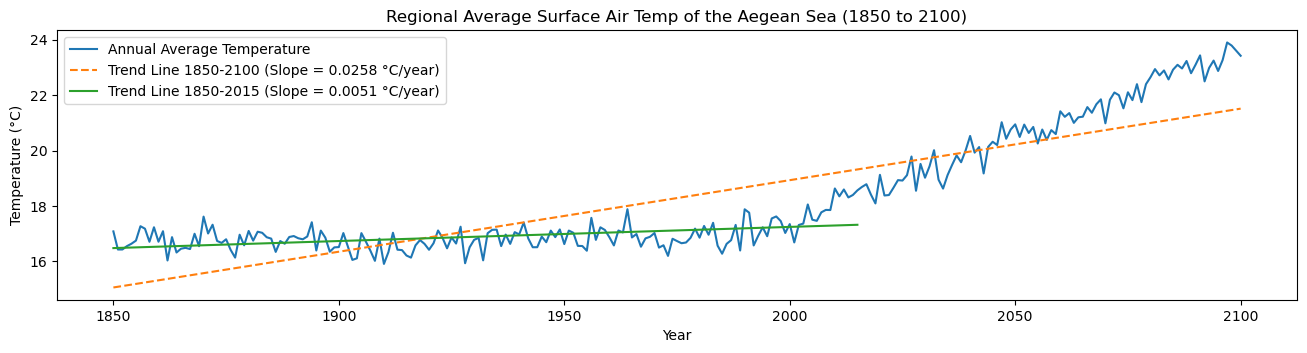

In [18]:
# plotting the two time series and their trend lines

fig, ax = plt.subplots(figsize=(16, 3.5))
ax.plot(years_2100, temps_2100, label="Annual Average Temperature")
ax.plot(years_2100, fit_2100, linestyle="--", label=f"Trend Line 1850-2100 (Slope = {coeffs_2100[0]:.4f} °C/year)")
ax.plot(years_2015, fit_2015, linestyle="-", label=f"Trend Line 1850-2015 (Slope = {coeffs_2015[0]:.4f} °C/year)")
ax.set_title("Regional Average Surface Air Temp of the Aegean Sea (1850 to 2100)")
ax.set_xlabel("Year")
ax.set_ylabel("Temperature (°C)")
ax.legend()
plt.show()

Over these two time periods, the temperature is certainly changing. From 1850 to 2015, the change is relatively insignificant. However from 1850 to the projected temperatures in 2100, the change is extremely significant. 

The results of this plot are alarming, to say the least. This model indicates a change of nearly 2 degrees celsius by 2050, which is significant especially in a region with mild Mediterranean weather. Other regions could experience much higher increases in temperature I would imagine. 

This increase in temperature would effect ocean life like kelp would be effected, and probably trigger mass die-offs. Desertification may also be a concern; 50% of the land area of Crete is already at risk of desertification. 

As for human systems, this temperature increase would effect crop yields for crops like olives, grapes, and citrus, and would likely shift their ideal growing regions further north up the Adriatic. Drought would also effect these yields, and would directly effect potable water availability for populated areas. Heat waves could also effect tourism; just last summer several tourists died due to the heat on the islands (although I believe these guys were hiking without water, always bring water). Islands would be effected by sea level rise, and coastal populations may be displaced. Low elevation archaeological/heritage sites could also be effected by sea level rise.